In [1]:
import numpy as np
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import permutationTest as pt

In [2]:
class memoryAllocationTest:
    def runTestInBatch(self, Abatch, Bbatch, sample_n, w):
        
        allPval = list()
        batchSize = len(Abatch)
        
        for j in range(0, batchSize, sample_n):
            
            Abatch_div = Abatch[j:j+sample_n][0]
            Bbatch_div = Bbatch[j:j+sample_n][0]
            
            pExactListNorm = pt.GreenFloatCuda(Abatch_div.reshape(1,-1), Bbatch_div.reshape(1,-1), w)
            allPval.append(pExactListNorm)
            
        return allPval

    def getTimeSeries(self, experiemnt_var, data_generator):
        
        ALLTimeList = list()
        
        setNList, sampleNList, NwList, batchsize, sampleRangeMax, mean, std = experiemnt_var
        
        for set_n, sample_n, w in zip(setNList, sampleNList, NwList):
            
            allTimes = list()
            
            AN, BN = [data_generator(mean, std, set_n, sampleRangeMax) , data_generator(mean, std,set_n,sampleRangeMax)]
            
            for i in range(0, len(AN), batchsize):
                
                Abatch = AN[:i+batchsize]
                Bbatch = BN[:i+batchsize]
                print("Batch len {}".format(len(Abatch)))
        
                start = time.time()
                allPval = self.runTestInBatch(Abatch, Bbatch, sample_n, w)
                end = time.time()
                dt = end - start
                allTimes.append(dt)
                print("------------")
                
            ALLTimeList.append(allTimes)
        return ALLTimeList

In [72]:
def preparePandas(timeData, sampleSizes, test="Parallel"):
    """Create DF for sns-plots"""
    
    preparePd = list()
    
    for time, sample in zip(timeData, sampleSizes):
        preparePd.append([str(test),time, sample])
              
    return preparePd

def memoryPlotSNS(ALLTimeList, names, variables, binVar=False, log=False, path=None, colors= ["r", "g", "b"]):
    """ Create memory plit"""
    
    def getXrangeData(setSize, maxRange, batchS):
        """Get range of data"""
        
        AN, BN = [np.random.normal(0,1,setSize) for i in range(maxRange)], [np.random.normal(0,1,setSize) for i in range(maxRange)]
        
        batchList = list()
        
        for i in range(0, len(AN), batchS):
            
            Abatch = AN[:i+batchS]
            batchList.append(len(Abatch))

        return batchList
    
    def getScatterData(sN,tList, maxRange, batchSize):
        y=list()
        x=list()
        for i, j in enumerate(range(0, maxRange, batchSize)):
            if j % sN ==0 and j!=0:
                y.append(j)
                x.append(tList[i-1])
        return x, y
    
    
    a4_dims = (11.7/1.5, 8.27/1.5)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.set(style="white")
    sns.set_context("talk")
    
    
    setN, sampleNList, sampleRangeMax, batchsize = variables
    batchList = getXrangeData(setN, sampleRangeMax, batchsize)
    
    
    for i, (time_list, name) in enumerate(zip(ALLTimeList, names)):
        if log:
            df = preparePandas(np.log10(time_list), batchList, name)
        else:
            df = preparePandas(time_list, batchList, name)
            
        if i ==0:
            data = df
        else:
            data += df
            
    df = pd.DataFrame(data, columns=['Experiment', 'time(s)',"Sample size"])
    
    palette = dict(zip(set(df.Experiment), colors))
    
    x = df["time(s)"].values
    
    if log:        
        MAX = max(x)
        MIN = min(x)
        


        RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
        snsPlot = sns.lineplot(x="Sample size", y="time(s)",
             hue="Experiment",
             data=df, palette=palette)#.set(yticks = RANGE, yticklabels=10**RANGE)
        plt.yticks(RANGE, 10.0**RANGE)
        
        
    else:
        snsPlot = sns.lineplot(x="Sample size", y="time(s)",
             hue="Experiment",
             data=df,palette=palette)
    
    if binVar:
        plt.xlabel(r"$n$")
        
    else:
        plt.xlabel(r"$n$")
    
    
    
    plt.legend(loc='upper left')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    

    plt.setp(snsPlot.get_legend().get_texts(), fontsize='12')
    
    sns.despine()
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.30)
    
    for N, Time, c in zip(sampleNList, ALLTimeList, colors):
        x, y = getScatterData(N,Time, sampleRangeMax, batchsize)
        plt.scatter(y, x, marker="o", color=c)

In [4]:
memTest = memoryAllocationTest()

data_generator = lambda mean, std, size ,n_samples : [np.random.normal(mean, std, size) for _ in range(n_samples)]

In [ ]:
def getPATH(path, suffix, prefix):
    return path + '/'+ suffix + '/' + prefix

In [ ]:
path = "figures/paralellVsFastApprox"

# Set size 500 and sample size up to 24

In [91]:
setNList = [500,500,500]
sampleNList = [2,20,4]
NwList = [2000,200,1000]
batchsize = 1
sampleRangeMax =24
mean = 0
std = 1

experiemnt_var = (setNList, sampleNList, NwList, batchsize, sampleRangeMax, mean, std)

In [92]:
#LargeSetSize_N = memTest.getTimeSeries(experiemnt_var, data_generator)

In [93]:
#pickle.dump(LargeSetSize_N, open("./experiment_data/experiment3/LargeSetSize", "wb"))
LargeSetSize = pickle.load(open("./experiment_data/experiment3/LargeSetSize", "rb"))

In [94]:
variables = (setNList[0], sampleNList, sampleRangeMax, batchsize)
names = ["$n_{w}=2000$", "$n_{w}=200$", "$n_{w}=1000$"]

In [95]:
sortVar = np.asarray(LargeSetSize).mean(1)
sortVar, names, LargeSetSize, sampleNList = (list(t) for t in zip(*sorted(zip(sortVar, names,LargeSetSize, sampleNList))))

In [96]:
variables = (setNList[0], sampleNList, sampleRangeMax, batchsize)

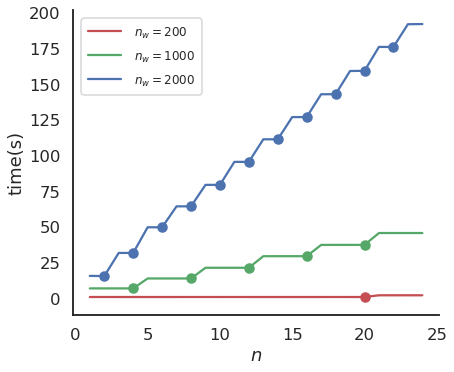

In [97]:
memoryPlotSNS(LargeSetSize, names,variables, log=False)

# Set size 40 and sample size up to 2700


In [84]:
batchsize = 100
setNList = [40,40,40]
sampleNList = [400,2500,600]
NwList = [1250,200,800]
sampleRangeMax= 2700
mean = 0
std = 1

experiemnt_var = (setNList, sampleNList, NwList, batchsize, sampleRangeMax, mean, std)

In [85]:
#ALLTimeList = memTest.getTimeSeries(experiemnt_var, data_generator)

In [86]:
#pickle.dump(ALLTimeList, open("./experiment_data/experiment3/smallSetSize.pkl", "wb"))
ALLTimeList = pickle.load(open("./experiment_data/experiment3/smallSetSize.pkl", "rb"))

In [87]:
names = ["$n_{w}=1250$", "$n_{w}=200$", "$n_{w}=800$"]

In [88]:
sortVar = np.asarray(ALLTimeList).mean(1)
sortVar, names, ALLTimeList, sampleNList, setNList = (list(t) for t in zip(*sorted(zip(sortVar, names,ALLTimeList, sampleNList, setNList))))

In [89]:
variables = (setNList[0], sampleNList, sampleRangeMax, batchsize)
names = ["$n_{w}=1250$", "$n_{w}=200$", "$n_{w}=800$"]


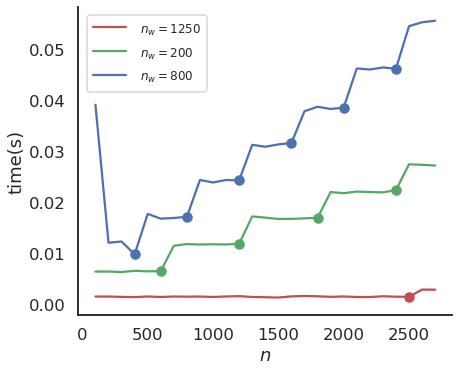

In [90]:
memoryPlotSNS(ALLTimeList, names,variables, log=False)